# Declarations

## Imports

In [1]:
import re
import os
import math
import string
import random
import requests
import importlib
import itertools

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import plotly.graph_objects as go

from tqdm import tqdm

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

tfk = tf.keras
tfkl = tf.keras.layers
kb = tf.keras.backend

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.13.0
Num GPUs Available:  1


## Constants

In [4]:
# Randomness
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
# Filepaths
kaggle = True

model_versions = ["v4.0"]

github_repo = "raul-singh/Rise-of-Transformers-Project"
github_branch = "main"
github_python_prefix = ["Code", "Notebooks", "py_files"]
github_clip_models_prefix = ["Code", "Models"] if kaggle else ["..", "Models"]
github_pyfiles_data = [
    {"name": "preprocessing", "imports": ["import_datasets"]},
    {"name": "evaluation", "imports": [
        "EvalMetrics as evm", "compute_total_relevance", "generate_image_embeddings", "generate_text_embeddings", 
        "find_t2i_matches", "find_i2t_matches", "index_to_reference", "compute_relevant_at_k"
    ]}, 
    {"name": "daug", "imports": ["RandomSwapWordsTTA"]},
    {"name": "clip", "imports": ["build_clip", "EncoderTTA"]}
]
github_pyfiles = ["/".join(github_python_prefix) + "/" + pf["name"] + ".py" for pf in github_pyfiles_data]
github_clip_models = [f"{'/'.join(github_clip_models_prefix)}/{version}.yaml" for version in model_versions]

kaggle_dataset1 = "/kaggle/input/transformers-hackathon/"
kaggle_dataset2 = "/kaggle/input/transformers-hackathon-features/"
kaggle_weights = "/kaggle/input/clip-weights/"
kaggle_relevance = "/kaggle/input/clip-relevance/"

image_dir = "./resized_train"
relevance_dir = "./relevance"
caption_pred_file = "caption_prediction_train.csv"
concept_det_file = "concept_detection_train.csv"
concept_file = "concepts.csv"
clip_weights_files = [f"{version}.h5" for version in model_versions] if kaggle else [None for _ in model_versions]

if kaggle:
    image_dir = kaggle_dataset1 + image_dir
    relevance_dir = kaggle_relevance + relevance_dir
    caption_pred_file = kaggle_dataset2 + caption_pred_file
    concept_det_file = kaggle_dataset2 + concept_det_file
    concept_file = kaggle_dataset2 + concept_file
    clip_weights_files = [kaggle_weights + weight for weight in clip_weights_files]

## Meta-Imports

In [6]:
def clean_recursive_imports(source, import_list, prefix):
    import_prefix = re.sub(r"/", ".", prefix)
    for target_import in import_list:
        source = re.sub(r"from[ \t]+" + re.escape(target_import) + r"[ \t]+import", f"from {import_prefix + target_import} import", source)
    return source
    
def import_py_from_repo(repository, branch, filepath, prefix, recursive_imports_list=None):
    # Build path for retrieval and write name
    path_pre = "https://raw.githubusercontent.com/"
    path = path_pre + repository + "/" + branch + "/" + filepath 
    write_path = prefix + filepath.split("/")[-1]
    print("Downloading file from " + path)
    # Obtain raw text from file
    text = requests.get(path).text
    # Clean recursive imports
    text = clean_recursive_imports(text, recursive_imports_list, prefix) if recursive_imports_list else text
    # Create subdirectories if not exist
    os.makedirs(os.path.dirname(write_path), exist_ok=True)
    # Write file
    f = open(write_path, "w")
    f.write(text)
    f.close()

In [7]:
if kaggle:
    for pf_data, py_file in zip(github_pyfiles_data, github_pyfiles):
        import_py_from_repo(
            github_repo, github_branch, py_file, 
            "/".join(github_python_prefix) + "/", 
            recursive_imports_list=[pf["name"] for pf in github_pyfiles_data],
        )
        import_string = f'from {".".join(github_python_prefix) + "." + pf_data["name"]} import {", ".join(pf_data["imports"])}'
        exec(import_string)
    
    for model in github_clip_models:
        import_py_from_repo(github_repo, github_branch, model, "/".join(github_clip_models_prefix) + "/")
        
else:
    for pf_data in github_pyfiles_data:
        import_string = f'from py_files.{pf_data["name"]} import {", ".join(pf_data["imports"])}'
        exec(import_string)

## Notebook Constants

In [8]:
# Train/Val/Test split and filter percentages
test_size = 0.2
val_size = 0
filter_percent_dataset = 1

# Batch size
batch_size = 32

# Apply tta
tta = False

# Import dataset types and shapes
in_feat_typ = {'caption': tf.string, 'concepts': tf.bool, 'image path': tf.string}
feature_shapes = {'image': (128, 128, 3), 'caption': (), 'concepts': (8374)}

# Output dataset structure
x_features_eval = ['image path', 'image']
y_features_eval = ['caption', 'concepts']

# Define parameters for dataset import
dataset_parameters = [{
    'x_features': x_features_eval, 'y_features': y_features_eval,
    'x_dict': True, 'y_dict': True,           
    'shuffle_buffer_size': 1,
    'batch_size': batch_size,
    'cached': True,
}]

# Test Time Augmentation pipelines and parameters
image_tta_pipeline = tfk.Sequential(
    [
        tfkl.RandomRotation(0.15, seed=seed),         # Rotation with factor
        tfkl.RandomContrast(0.2, seed=seed),         # Contrast with factor
        tfkl.RandomBrightness(0.25, (0,25), seed=seed), # Brightness with factor and range
    ]
)
text_tta_pipeline = tfk.Sequential([
    RandomSwapWordsTTA(p=0.8, seed=seed),                # Swap random words with probability p
])
tta_n = 10

# Preprocessing

In [9]:
concept_info, datasets, dataset_sizes = import_datasets(
    image_dir, caption_pred_file, concept_file, concept_det_file,
    in_feat_typ, feature_shapes,
    dataset_parameters,
    filter_percent_dataset,
    test_size, val_size,
    seed,
)

Extracting features from CSV file(s)


83275it [01:22, 1006.03it/s]


In [10]:
# Select loaded datasets and variables
concept_list, concepts_onehot = concept_info
_, _, test_dataset = datasets[0]
train_ds_size, val_ds_size, test_ds_size = dataset_sizes

del datasets

# Model Import

In [11]:
models = []
for structure, weights in zip(github_clip_models, clip_weights_files):
    print(f"Creating model {structure}")
    clip_image_encoder, clip_text_encoder, clip = build_clip(structure, weights_path="/kaggle/input/clip-weights/v4.0.h5")
    models.append({
        "image_encoder": clip_image_encoder,
        "clip_text_encoder": clip_text_encoder,
        "clip": clip,
    })

Creating model Code/Models/v4.0.yaml
82420632/82420632 [==============================] - 1s 0us/step
Models downloaded.
Building clip...
Loading parameters...
Done.


In [12]:
# Select the loaded model to evaluate
clip_image_encoder, clip_text_encoder, clip = models[0].values()

del models

In [13]:
# Wrap encoders into TTA encoders
if tta:
    clip_image_encoder = EncoderTTA(clip_image_encoder, image_tta_pipeline, tta_n)
    clip_text_encoder = EncoderTTA(clip_text_encoder, text_tta_pipeline, tta_n)

# Playground

## Functions

In [14]:
def convert_ds_images(dataset, skip_take_pairs=[(0,1)]):
    return dataset.unbatch().map(lambda x, y: (x["image"], x["image path"])).batch(1)

In [22]:
# Visualizes a series of matches
def visualize_matches(matches):
    if "image path" in matches[0]:
        fig = plt.figure(figsize=(4, 4))
    for i, match in enumerate(matches):
        if "image path" in matches[i]:
            path = match["image path"].numpy().decode('UTF-8')
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(mpimg.imread(path))
            plt.axis("off")
        if "caption" in matches[i]:
            caption = match["caption"].numpy().decode('UTF-8')
            print(f"{i+1}) {caption}")
    display(fig)
    plt.close()
    
# Visualize results for text to image queries
def visualize_t2i_results(query, matches):
    print("Top matches for query: \"" + query + "\"")
    visualize_matches(matches)

# Visualize results for image to text queries
def visualize_i2t_results(query, matches):
    print("Top matches for query:")
    path = query[1].numpy().decode('UTF-8')
    fig = plt.figure(figsize=(2, 2))
    plt.imshow(mpimg.imread(path))
    plt.axis("off")
    display(fig)
    plt.close()
    visualize_matches(matches)

In [16]:
# Manually compute some text to image queries
def manual_t2i_queries(queries, text_encoder, image_embeddings, dataset_reference, k=10, normalize=True):
    results = find_t2i_matches(queries, text_encoder, image_embeddings, k=k, normalize=normalize)
    results = index_to_reference(results, dataset_reference)
    for query, matches in zip(queries, results):
        visualize_t2i_results(query, matches)

# Manually compute some image to text queries
def manual_i2t_queries(queries, image_encoder, text_embeddings, dataset_reference, k=10, normalize=True):
    results = find_i2t_matches(queries, image_encoder, text_embeddings, k=k, normalize=normalize)
    results = index_to_reference(results, dataset_reference)
    for query, matches in zip(queries.unbatch(), results):
        visualize_i2t_results(query, matches) 

## Dataset Metrics

In [18]:
# Generating embeddings for image-to-text and text-to-image tasks
dataset_reference, image_embeddings = generate_image_embeddings(
    clip_image_encoder,
    test_dataset,
    dataset_pred_map=lambda x, y: x['image'],
    dataset_ref_map=lambda x, y: y | {'image path': x['image path']}
)

_, text_embeddings = generate_text_embeddings(
    clip_text_encoder,
    test_dataset,
    dataset_pred_map=lambda x, y: y['caption'],
    dataset_ref_map=lambda x, y: y | {'image path': x['image path']}
)

Generating image embeddings
521/521 [==============================] - 15s 29ms/step
Generating text embeddings
521/521 [==============================] - 39s 75ms/step


## Text to Image

Computing Text-to-Image matches
1/1 [==============================] - 0s 41ms/step
Top matches for query: "brain"
1) weight mri show right hippocampal volume loss and a mild dilation of the right temporal horn
2) axial  contrast image show almost complete resolution of the temporal lobe lesion with mild dilatation of the left temporal horn
3) coronal  flair on magnetic resonance imaging mri of brain


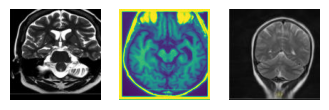

Top matches for query: "lungs"
1) man  year old with right lung abscess after admission to the centre
2) the confirmation of right reexpansion by chest xray reexpansion pulmonary edema be also see
3) figure  the double bubble sign


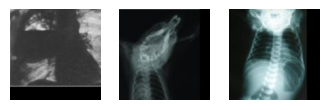

In [20]:
k = 3
queries = ["brain", "lungs"]
manual_t2i_queries(queries, clip_text_encoder, image_embeddings, dataset_reference, k=k)

## Image to Text

Computing Image-to-Text matches
2/2 [==============================] - 0s 40ms/step
Top matches for query:


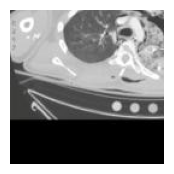

1) computed tomography take after bronchoscopy
2) preoperative chest compute tomography ct preoperative chest ct scan show a foreign body in the carina and right proximal main bronchus
3) ct scan demonstrate the resolution of infection it be well evident the chest drain within mediastinum on the right side that allow the drainage of infection


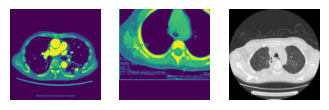

Top matches for query:


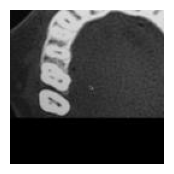

1) axial cone beam compute tomography view show two distinct canal in the mesiobuccal root of the maxillary right first molar tooth
2) determine the cbct cross section in an axial view
3) cbct show the border of the lesion and the perforation area


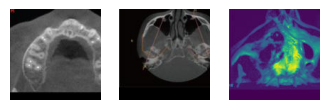

In [28]:
k = 3
queries = convert_ds_images(test_dataset).skip(13).take(2)
manual_i2t_queries(queries, clip_image_encoder, text_embeddings, dataset_reference, k=k)